<a href="https://colab.research.google.com/github/ahmadSoliman94/Computer-Vision-projects/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=ec4daaaf2466ebe949d17782463f72247ee998b7b7c0741f7fff01d7f160953f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f03b4cb3d443bbc0d3cc4710c204a

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 33.56 MiB/s, done.
Resolving deltas: 100% (3/3), done.


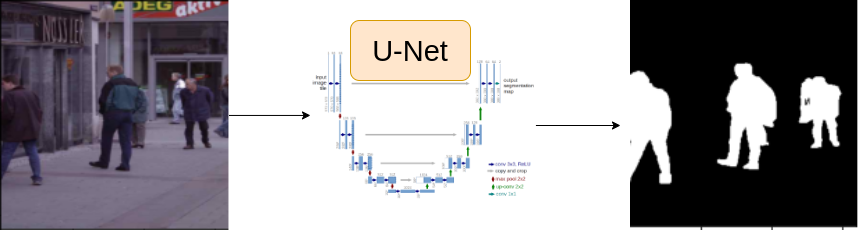

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [325]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [326]:
# Specifies the path to the CSV file containing training data
CSV_file = '/content/Human-Segmentation-Dataset-master/train.csv'

# Specifies the directory where the data is located
Data_dir = '/content'

# Specifies the device to be used for computation (GPU in this case)
DEVICE = 'cuda'

# Specifies the number of training epochs
EPOCHS = 25

# Specifies the learning rate for the optimizer
LR = 0.003

# Specifies the batch size 
BATCH_SIZE = 16

# Specifies the size of the input images for the model
IMG_SIZE = 256 

# Specifies the encoder architecture to be used (timm-efficient-b0)
ENCODER = 'resnet18'

# Specifies the pre-trained weights to be used for the encoder (Imagenet weights)
WEIGHTS = 'imagenet'


In [327]:
# Read the CSV file into a DataFrame using the specified file path
df = pd.read_csv(CSV_file)

# Display the first few rows of the DataFrame
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [328]:
# Access the fifth row of the DataFrame using iloc indexing
row = df.iloc[4]

# Retrieve the value in the 'images' column of the fifth row and assign it to 'image_path'
image_path = row.images

# Retrieve the value in the 'masks' column of the fifth row and assign it to 'mask_path'
mask_path = row.masks

# Read the image file specified by 'image_path' using OpenCV
image = cv2.imread(image_path)

# Convert the color space of the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the mask file specified by 'mask_path' using OpenCV, and convert it to grayscale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Normalize the pixel values of the mask to the range [0, 1] by dividing by 225.0
mask = mask / 225.0

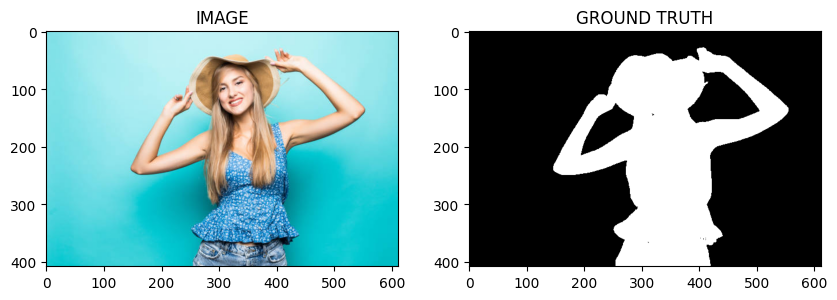

In [329]:
# Create a figure and two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Set the title for the first subplot
ax1.set_title('IMAGE')

# Display the image in the first subplot
ax1.imshow(image)

# Set the title for the second subplot
ax2.set_title('GROUND TRUTH')

# Display the mask image in the second subplot using grayscale colormap
ax2.imshow(mask, cmap='gray')

In [330]:
# Split the DataFrame into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Print the shape of the training data (number of rows and columns)
print(f'Shape of train data: {train_df.shape}')

# Print the shape of the validation data (number of rows and columns)
print(f'Shape of validation data: {valid_df.shape}')

Shape of train data: (232, 2)
Shape of validation data: (58, 2)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [331]:
import albumentations as A

In [332]:
def get_train_augs():
    """
    Define the augmentation pipeline for training data.
    """
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)  # Disable shape check

def get_valid_augs():
    """
    Define the augmentation pipeline for validation data.
    """
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)  # Disable shape check

# Task 4 : Create Custom Dataset 

In [333]:
from torch.utils.data import Dataset

In [334]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        """
        Initialize the SegmentationDataset class.

        Args:
            df (pandas DataFrame): DataFrame containing image and mask file paths.
            augmentations (albumentations.Compose, optional): Augmentation pipeline to be applied to the data.
                Defaults to None.
        """
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            image (torch.Tensor): Preprocessed image tensor.
            mask (torch.Tensor): Preprocessed mask tensor.
        """
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        # Read the image file and convert color space to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the mask file and convert color space to grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask,axis = -1)

        if self.augmentations:
            # Apply augmentations to the image and mask
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask,(2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask


In [335]:
# Create an instance of SegmentationDataset for the training set
trainset = SegmentationDataset(train_df, get_train_augs())

# Create an instance of SegmentationDataset for the validation set
validset = SegmentationDataset(valid_df, get_valid_augs())



In [336]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


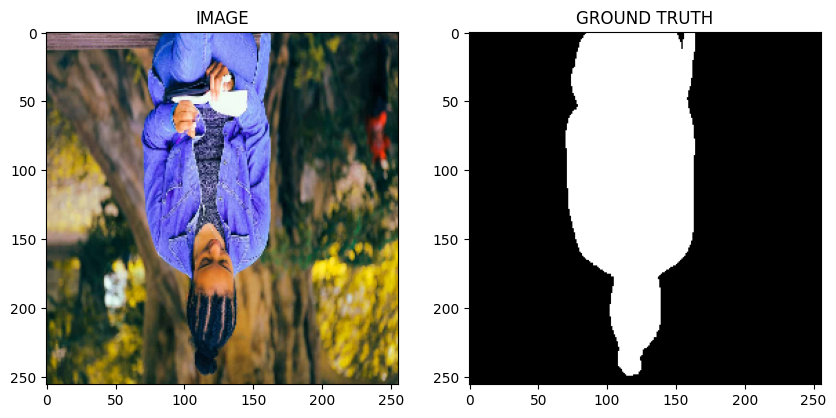

In [337]:
idx = 30

image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [338]:
from torch.utils.data import DataLoader

In [339]:
# Create a data loader for the training set
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the validation set
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [340]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [341]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 256, 256])
One batch mask shape : torch.Size([16, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [342]:
from torch import nn 
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [343]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        # Define the UNet model for segmentation
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    
    def forward(self, images, masks=None):
        # Pass the images through the UNet model
        logits = self.arc(images)
        
        if masks is not None:
            # Calculate the Dice loss for segmentation evaluation
            loss1 = DiceLoss(mode='binary')(logits, masks)
            # Calculate the binary cross-entropy with logits loss
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits


In [344]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

# Task 7 : Create Train and Validation Function 

In [345]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    
    # Iterate over the data loader using tqdm for progress visualization
    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Return the average loss over the entire data loader
    return total_loss / len(data_loader)

In [346]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    
    # Disable gradient calculation since no backpropagation is needed
    with torch.no_grad():
        # Iterate over the data loader using tqdm for progress visualization
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits, loss = model(images, masks)
            total_loss += loss.item()
    
    # Return the average loss over the entire data loader
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [347]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [348]:
# Set the initial best_valid_loss to infinity
best_valid_loss = np.Inf

# Iterate over the epochs
for i in range(EPOCHS):

    # Perform the training step and obtain the train_loss
    train_loss = train_fn(trainloader, model, optimizer)

    # Perform the evaluation step and obtain the valid_loss
    valid_loss = eval_fn(validloader, model)

    # Check if the current valid_loss is smaller than the best_valid_loss
    if valid_loss < best_valid_loss:
        # Save the model's state dictionary to 'best_model.pt'
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")

        # Update the best_valid_loss to the current valid_loss
        best_valid_loss = valid_loss

    # Print the epoch number, train_loss, and valid_loss
    print(f"Epoch : {i+1} Train loss : {train_loss} Valid loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


SAVED-MODEL
Epoch : 1 Train loss : 0.9320618271827698 Valid loss : 23.328566074371338


100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


SAVED-MODEL
Epoch : 2 Train loss : 0.757739766438802 Valid loss : 17.69292116165161


100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


SAVED-MODEL
Epoch : 3 Train loss : 0.6724133253097534 Valid loss : 3.1299057602882385


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


SAVED-MODEL
Epoch : 4 Train loss : 0.6014867027600607 Valid loss : 0.6864148825407028


100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Epoch : 5 Train loss : 0.5976776083310446 Valid loss : 0.7787978947162628


100%|██████████| 4/4 [00:00<00:00,  7.12it/s]


SAVED-MODEL
Epoch : 6 Train loss : 0.5413764516512553 Valid loss : 0.5913860723376274


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


SAVED-MODEL
Epoch : 7 Train loss : 0.47405222853024803 Valid loss : 0.5666283443570137


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


SAVED-MODEL
Epoch : 8 Train loss : 0.45144079128901166 Valid loss : 0.4428451657295227


100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


SAVED-MODEL
Epoch : 9 Train loss : 0.41595248182614647 Valid loss : 0.43758755177259445


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch : 10 Train loss : 0.4055602490901947 Valid loss : 0.5025860294699669


100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


Epoch : 11 Train loss : 0.42236410776774086 Valid loss : 0.6203315332531929


100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


SAVED-MODEL
Epoch : 12 Train loss : 0.3948797384897868 Valid loss : 0.3908766135573387


100%|██████████| 4/4 [00:00<00:00,  7.24it/s]


SAVED-MODEL
Epoch : 13 Train loss : 0.3663161605596542 Valid loss : 0.3386143818497658


100%|██████████| 4/4 [00:00<00:00,  6.90it/s]


Epoch : 14 Train loss : 0.3290836383899053 Valid loss : 0.35332655906677246


100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


Epoch : 15 Train loss : 0.3938229898611704 Valid loss : 0.5512928292155266


100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


Epoch : 16 Train loss : 0.31843509276707965 Valid loss : 0.5349361896514893


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Epoch : 17 Train loss : 0.3101690590381622 Valid loss : 0.39845871925354004


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


SAVED-MODEL
Epoch : 18 Train loss : 0.28115762074788414 Valid loss : 0.3037678301334381


100%|██████████| 4/4 [00:00<00:00,  7.12it/s]


Epoch : 19 Train loss : 0.28185534874598184 Valid loss : 0.42654935270547867


100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


Epoch : 20 Train loss : 0.285915607213974 Valid loss : 0.3664871007204056


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch : 21 Train loss : 0.231620129942894 Valid loss : 0.4215971529483795


100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


Epoch : 22 Train loss : 0.22927026351292928 Valid loss : 0.3404143378138542


100%|██████████| 4/4 [00:00<00:00,  6.90it/s]


Epoch : 23 Train loss : 0.232606440782547 Valid loss : 0.35714349150657654


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 24 Train loss : 0.259075732032458 Valid loss : 0.32727617770433426


100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

Epoch : 25 Train loss : 0.2849557280540466 Valid loss : 0.49090055376291275


# Task 9 : Inference

In [349]:
idx = 2

# Load the state dictionary of the model from the saved file
model.load_state_dict(torch.load('/content/best_model.pt'))

# Get the image and mask from the validation set at index idx
image, mask = validset[idx]

# Forward pass through the model to obtain the logits
logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)

# Apply sigmoid activation function to obtain the predicted mask
pred_mask = torch.sigmoid(logits_mask)

# Binarize the predicted mask using a threshold of 0.5
binary_mask = (pred_mask > 0.5)*1.0 


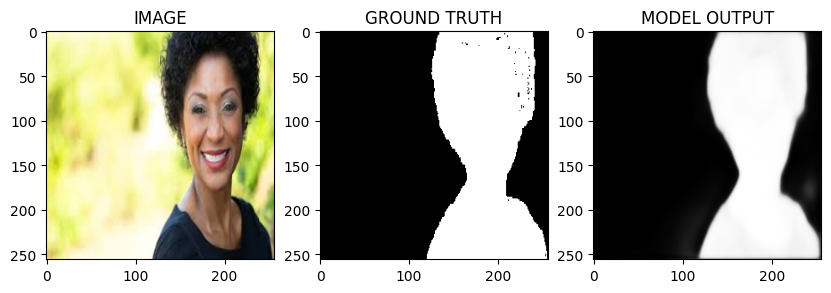

In [350]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya